In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('/content/monthly-oil-production (1).csv')
df.head()

,Country name,Month,Monthly oil production
0,Canada,1973-01-01,8604000
1,Canada,1973-02-01,8671000
2,Canada,1973-03-01,8836000
3,Canada,1973-04-01,8647000
4,Canada,1973-05-01,8328000


In [3]:
df['Date'] = pd.to_datetime(df['Month'])

df.groupby('Date').sum()

,Country name,Month,Monthly oil production
Date,,,
1973-01-01,Canada,1973-01-01,8604000
1973-02-01,Canada,1973-02-01,8671000
1973-03-01,Canada,1973-03-01,8836000
1973-04-01,Canada,1973-04-01,8647000
1973-05-01,Canada,1973-05-01,8328000
...,...,...,...
2021-06-01,Canada,2021-06-01,21490000
2021-07-01,Canada,2021-07-01,21770000
2021-08-01,Canada,2021-08-01,21430000


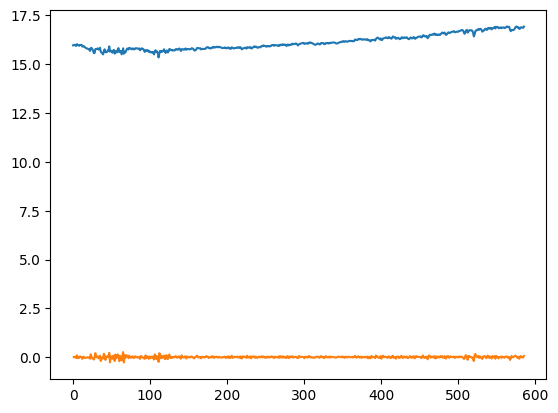

In [ ]:
df['Original'] = df['Monthly oil production']
df['Monthly oil production'] = np.log(df['Monthly oil production'].values)

plt.plot(df['Monthly oil production'])

plt.plot(df['Monthly oil production'].diff().dropna())
plt.show()

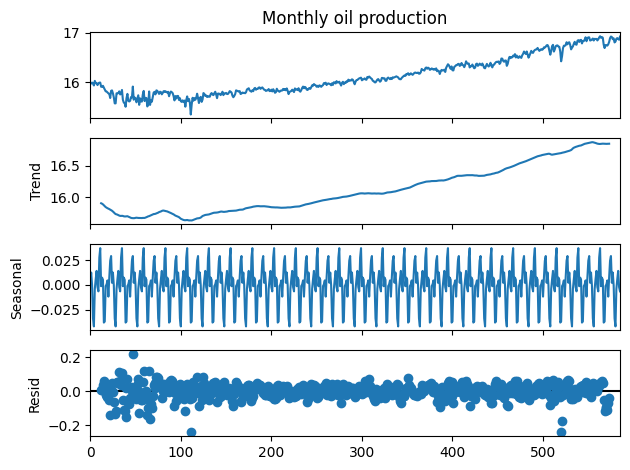

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_seasonal = seasonal_decompose(df['Monthly oil production'], model='additive', period=24)

result_seasonal.plot()
plt.show()

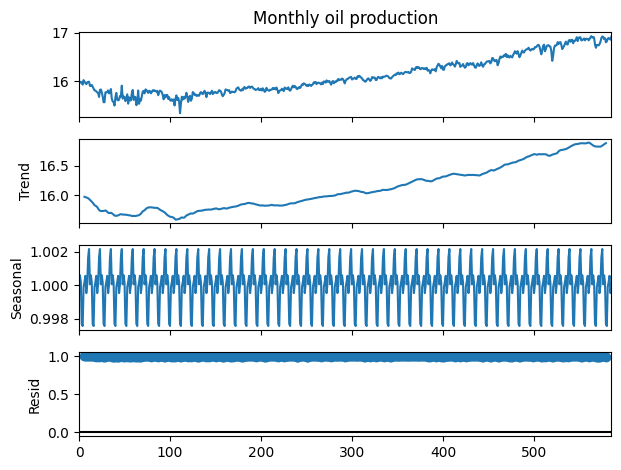

In [ ]:
result_seasonal_mult = seasonal_decompose(df['Monthly oil production'], model='multiplicative', period=12)

result_seasonal_mult.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Monthly oil production'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


# plt.plot(airpass)

ADF Statistic: 0.773370
p-value: 0.991194


In [ ]:
result_diff = adfuller(df['Monthly oil production'].diff().dropna())
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])

ADF Statistic: -5.225320
p-value: 0.000008


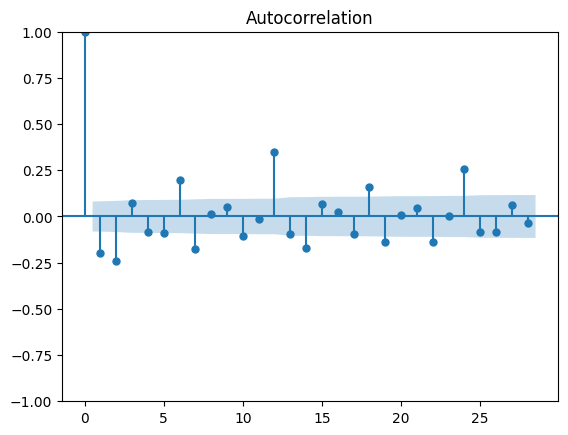

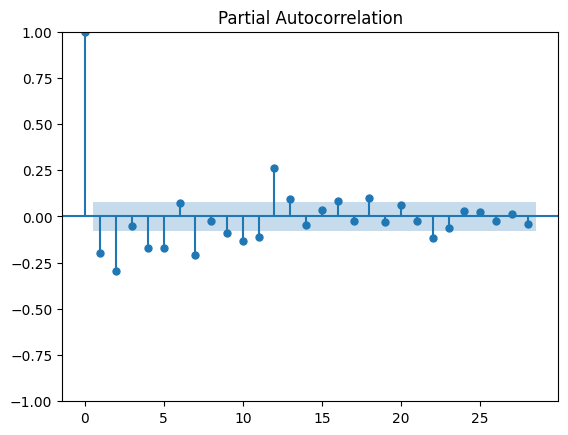

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Monthly oil production'].diff().dropna())
plt.show()

plot_pacf(df['Monthly oil production'].diff().dropna())
plt.show()


In [ ]:
train = df.iloc[:int(0.8*(len(df)))]
test = df.iloc[int(0.8*(len(df))):]

<ipython-input-11-c11d8445ddde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'mean_prediction']= train["Original"].mean()
<ipython-input-11-c11d8445ddde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'last_year_mean']=train["Original"][-13:-1].mean()
<ipython-input-11-c11d8445ddde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

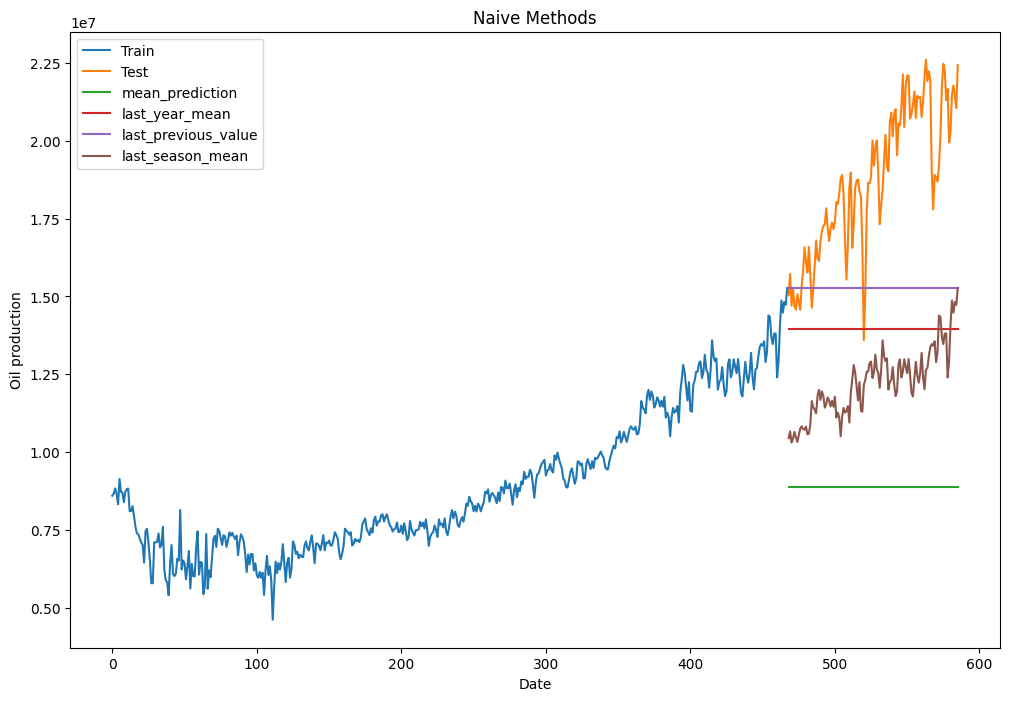

In [ ]:
test.loc[:,'mean_prediction']= train["Original"].mean()
test.loc[:,'last_year_mean']=train["Original"][-13:-1].mean()
test.loc[:,'last_previous_value']=train["Original"].iloc[-1]
test.loc[:,'last_season_mean']=train['Original'][-(len(test)):].values
plt.figure(figsize=(12,8))
plt.plot(train["Original"],label="Train")
plt.plot(test["Original"],label="Test")
plt.plot(test['mean_prediction'],label='mean_prediction')
plt.plot(test['last_year_mean'],label='last_year_mean')
plt.plot(test['last_previous_value'],label='last_previous_value')
plt.plot(test['last_season_mean'],label='last_season_mean')
plt.xlabel('Date')
plt.ylabel('Oil production')
plt.title('Naive Methods')
plt.legend()
plt.show()

Mean_error: 0.5185271156506456
last_firsthalf_year_mean_error: 0.2426188922381715
last_previous_value_error: 0.17779814466698415
last_season_mean_error: 0.3415167342102996


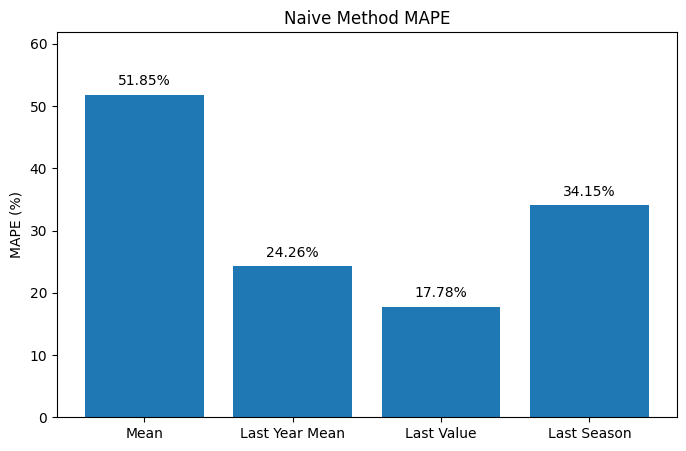

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

Mean_error = mean_absolute_percentage_error(test['Original'], test['mean_prediction'])
last_firsthalf_year_mean_error = mean_absolute_percentage_error(test['Original'], test['last_year_mean'])
last_previous_value_error = mean_absolute_percentage_error(test['Original'], test['last_previous_value'])
last_season_mean_error = mean_absolute_percentage_error(test['Original'], test['last_season_mean'])

print('Mean_error:', Mean_error)
print('last_firsthalf_year_mean_error:', last_firsthalf_year_mean_error)
print('last_previous_value_error:', last_previous_value_error)
print('last_season_mean_error:', last_season_mean_error)

methods = ['Mean', 'Last Year Mean', 'Last Value', 'Last Season']
mape_values = [Mean_error, last_firsthalf_year_mean_error, last_previous_value_error, last_season_mean_error]

plt.figure(figsize=(8,5))
bars = plt.bar(methods, [m * 100 for m in mape_values], )

# Add percentage labels on top of bars
for bar, value in zip(bars, mape_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f'{value * 100:.2f}%', ha='center', va='bottom', fontsize=10)

plt.ylabel('MAPE (%)')
plt.title('Naive Method MAPE')
plt.ylim(0, max(mape_values)*100 + 10)
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm


def opti(p):
  # train = new_df[:int(0.8*len(new_df))]
  # test_ma = new_df[int(0.8*len(new_df)):]

  ar_model = ARIMA(train['Monthly oil production'],order = (p,1,0))
  ar_model = ar_model.fit()

  predict = ar_model.predict(start = len(train), end = len(test)+len(train)-1)
  print(p)
  print(mean_absolute_percentage_error(test['Monthly oil production'], predict))



  mape = mean_absolute_percentage_error(test['Monthly oil production'], predict)
  return mape



min_mape = 1e9
order_p = -1

for i  in range(1,13):
  mape = opti(i)
  if mape < min_mape:
    min_mape = mape
    order_p = i
print(min_mape)
print(order_p)


1
0.012398348460251247
2
0.012682608724334625
3
0.01274531687124633
4
0.012903787133403257
5
0.013252215819106381
6
0.012665676383689272
7
0.013739930266998695
8
0.01383780296629989
9
0.014030178920897394
10
0.014301489192559367
11
0.01465777244335732
12
0.013881214759442921
0.012398348460251247
1


In [ ]:
print(mape)
print(order_p)

0.013881214759442921
1


0.012398348460251247
468    16.532073
469    16.534490
470    16.533864
471    16.534026
472    16.533984
         ...    
581    16.533992
582    16.533992
583    16.533992
584    16.533992
585    16.533992
Name: predicted_mean, Length: 118, dtype: float64
0.18253856401943166


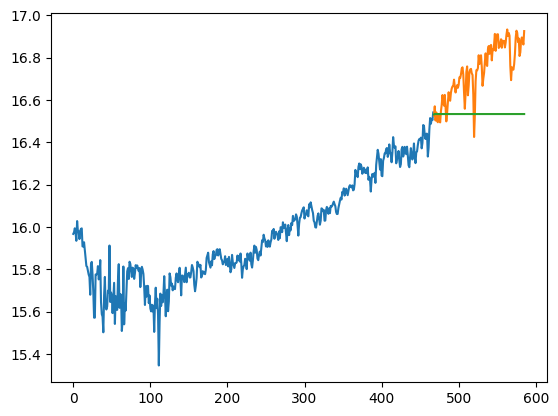

In [ ]:
ar_model = ARIMA(train['Monthly oil production'],order = (1,1,0))
ar_model = ar_model.fit()

predict = ar_model.predict(start = len(train), end = len(test)+len(train)-1)
# print(p)
print(mean_absolute_percentage_error(test['Monthly oil production'], predict))

print(predict)

mape_ar = mean_absolute_percentage_error(np.exp(test['Monthly oil production']), np.exp(predict))
print(mape_ar)
plt.plot((train['Monthly oil production']))
plt.plot(test['Monthly oil production'])
plt.plot((predict))
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm


def opti(q):
  # train = new_df[:int(0.8*len(new_df))]
  # test_ma = new_df[int(0.8*len(new_df)):]

  ma_model = ARIMA(train['Monthly oil production'],order = (0,1,q))
  ma_model = ma_model.fit()

  predict = ma_model.predict(start = len(train), end = len(test)+len(train)-1)
  print(q)
  print(mean_absolute_percentage_error(test['Monthly oil production'], predict))



  mape = mean_absolute_percentage_error(test['Monthly oil production'], predict)
  return mape



min_mape = 1e9
order_q = -1

for i  in range(1,13):
  mape = opti(i)
  if mape < min_mape:
    min_mape = mape
    order_q = i
print(min_mape)
print(order_q)


1
0.013214559028296177
2
0.014153404788869105
3
0.013940697035064183
4
0.014124624106369194
5
0.014253385246409251
6
0.013371506848253324


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7
0.013673831534390222
8
0.013513646176084245
9
0.013487962437006642


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10
0.013466461067932606


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11
0.013175436044448381
12
0.01274662811265843
0.01274662811265843
12


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.1870842366847833


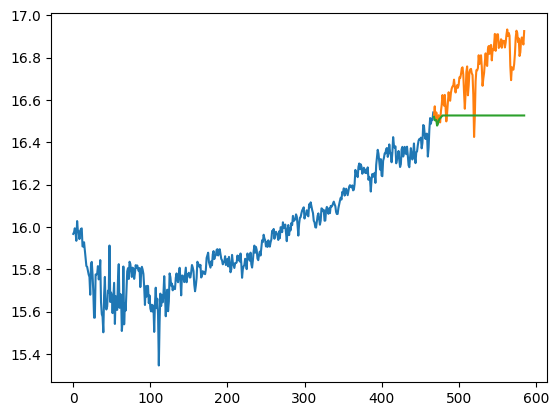

In [ ]:
ma_model = ARIMA(train['Monthly oil production'],order = (0,1,12))
ma_model = ma_model.fit()

predict = ma_model.predict(start = len(train), end = len(test)+len(train)-1)
# print(p)




mape_ma = mean_absolute_percentage_error(np.exp(test['Monthly oil production']), np.exp(predict))

print(mape_ma)
plt.plot((train['Monthly oil production']))
plt.plot(test['Monthly oil production'])
plt.plot((predict))
plt.show()

In [ ]:
def evaluate_arima_model(train, test, order):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    mape = mean_absolute_percentage_error(test['Monthly oil production'], predictions)
    aic_for_model = model_fit.aic
    return mape,aic_for_model

min_aic=1e9
opti_p = 0
opti_q = 0
opti_P =0
opti_Q =0
opti_season=0
counter=0
for p in range(1,4):

  for q in range(1,4):
            print("*"*30,counter,"*"*30)
            counter+=1
            mape,aic = evaluate_arima_model(train['Monthly oil production'], test, (p, 1, q))
            print(mape)
            if aic < min_aic:
              min_error = min_aic
              opti_p = p
              opti_q = q


print(opti_p)
print(opti_q)
print(min_aic)



****************************** 0 ******************************
0.014271082743413972
****************************** 1 ******************************
0.013959928041573337
****************************** 2 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.014370385415901816
****************************** 3 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.013945599870196126
****************************** 4 ******************************
0.01395509886417313
****************************** 5 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.013785608726734693
****************************** 6 ******************************
0.014118400875417386
****************************** 7 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.014145153209384113
****************************** 8 ******************************
0.014058845761942655
3
3
1000000000.0


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE:  0.014058845761942655
Test AIC:  -1512.863212774738


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


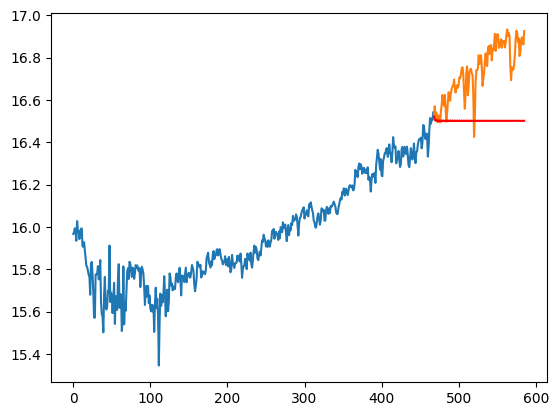

In [ ]:
model = ARIMA(train['Monthly oil production'], order=(3,1,3))
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
mape_arima = mean_absolute_percentage_error(np.exp(test['Monthly oil production']), np.exp(predictions))
aic_for_model = model_fit.aic
print('Test MAPE: ' , mape)
print('Test AIC: ' , aic_for_model)
plt.plot(train['Monthly oil production'])
plt.plot(test['Monthly oil production'])
plt.plot(predictions, color='red')
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

def evaluate_sarima_model(train, test, order,seasonal_order):
    model = ARIMA(train, order=order,seasonal_order=seasonal_order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    mape = mean_absolute_percentage_error(test['Monthly oil production'], predictions)
    aic_for_model = model_fit.aic
    return mape


In [ ]:
min_error=1e9
opti_p = 0
opti_q = 0
opti_P =0
opti_Q =0
opti_season=0
counter=0
for p in range(1,4):

  for q in range(1,4):
    for P in range(1,4):

      for Q in range(1,4):

          for seasonal in [6,12]:

            print("*"*30,counter,"*"*30)
            counter+=1
            error = evaluate_sarima_model(train['Monthly oil production'], test, (p, 1, q),(P,1,Q,seasonal))
            print(error)
            if error < min_error:
              min_error = error
              opti_p = p
              opti_q = q
              opti_P = P
              opti_Q = Q
              opti_season=seasonal


****************************** 0 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0033880068634355148
****************************** 1 ******************************
0.004707959433163607
****************************** 2 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003491533835639188
****************************** 3 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004810335333327632
****************************** 4 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0036359280013081715
****************************** 5 ******************************
0.0047635112243553475
****************************** 6 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.00440648684340832
****************************** 7 ******************************
0.0049061711531030675
****************************** 8 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003952760907666187
****************************** 9 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0047385961499696715
****************************** 10 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004731787090482417
****************************** 11 ******************************
0.004732536592879075
****************************** 12 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.009872189130990623
****************************** 13 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005102561865538409
****************************** 14 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003959871441882165
****************************** 15 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.00497132225461495
****************************** 16 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0047427081283915274
****************************** 17 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004977801014808736
****************************** 18 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003052148108679905
****************************** 19 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004419605958916631
****************************** 20 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0032149549635322083
****************************** 21 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004516571393263798
****************************** 22 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0031301904211597435
****************************** 23 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004472151937245884
****************************** 24 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0033224712779254466
****************************** 25 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004517486057337246
****************************** 26 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003186328323485771
****************************** 27 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0044274461199150855
****************************** 28 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005305153502693313
****************************** 29 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004484040096972646
****************************** 30 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.011426921152663147
****************************** 31 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004725798375576576
****************************** 32 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003324602985514993
****************************** 33 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004536288481120039
****************************** 34 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0030902829214932877
****************************** 35 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004325682677626096
****************************** 36 ******************************
0.003112090312466111
****************************** 37 ******************************
0.004446285614751507
****************************** 38 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0032972817818142683
****************************** 39 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0045059778852839785
****************************** 40 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0032921901255938326
****************************** 41 ******************************
0.0044947938459699716
****************************** 42 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003359601372338224
****************************** 43 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004617809479647762
****************************** 44 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003393023957132214
****************************** 45 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004440297106513389
****************************** 46 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003196737753548596
****************************** 47 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004512859499338082
****************************** 48 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.012345048179902812
****************************** 49 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004716069821731231
****************************** 50 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0034711916821366425
****************************** 51 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004601925698800576
****************************** 52 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0028897757726553336
****************************** 53 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004405225456512665
****************************** 54 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003040579525148775
****************************** 55 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0039568147058191595
****************************** 56 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003214347094374713
****************************** 57 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004399312728908576
****************************** 58 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003455169501328902
****************************** 59 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004576946553634832
****************************** 60 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003564245578880276
****************************** 61 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0045281528978143425
****************************** 62 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003221646568947398
****************************** 63 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004562071829072741
****************************** 64 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0040768423710075925
****************************** 65 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004544344166073493
****************************** 66 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.011372830884367016
****************************** 67 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004745199659063085
****************************** 68 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.00385811674183097
****************************** 69 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004573449962809258
****************************** 70 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003131610628826122
****************************** 71 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004600587478321764
****************************** 72 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0032374134190528985
****************************** 73 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004610060095102376
****************************** 74 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0030600326440916393
****************************** 75 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004571457437475653
****************************** 76 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0035152151649187145
****************************** 77 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004552774276614649
****************************** 78 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003213110385021399
****************************** 79 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004716350034818654
****************************** 80 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0036256872916824467
****************************** 81 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004531092632039151
****************************** 82 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003258327543373559
****************************** 83 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004582876768540429
****************************** 84 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.011130138280820566
****************************** 85 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004880010326488742
****************************** 86 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.002984886960114946
****************************** 87 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004768534554932614
****************************** 88 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0034506427953659826
****************************** 89 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004542288581707504
****************************** 90 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0032144046170962458
****************************** 91 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.00447104079646445
****************************** 92 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0029908511484791193
****************************** 93 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0045859665707014795
****************************** 94 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003546620373487889
****************************** 95 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004561678852408883
****************************** 96 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004125843022506382
****************************** 97 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004774125038276437
****************************** 98 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003663952055751665
****************************** 99 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004506257245636278
****************************** 100 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0031299749161812092
****************************** 101 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004660228759686224
****************************** 102 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.010907035473053247
****************************** 103 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004921264198680255
****************************** 104 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004130003291981956
****************************** 105 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004801756200389329
****************************** 106 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003256882851800578
****************************** 107 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0046349280386905065
****************************** 108 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004134858887042688
****************************** 109 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.00445065651295958
****************************** 110 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0030439075633506237
****************************** 111 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004690952953986937
****************************** 112 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0029903461924372992
****************************** 113 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004559939324530524
****************************** 114 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003702869230738949
****************************** 115 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004820613910618539
****************************** 116 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0030299898217833014
****************************** 117 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004999846364662859
****************************** 118 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0030539459692857777
****************************** 119 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004380896924550995
****************************** 120 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004743520527483379
****************************** 121 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004512717657185752
****************************** 122 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004121867433267097
****************************** 123 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004348844692293419
****************************** 124 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003275459945095539
****************************** 125 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004644100686023403
****************************** 126 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0030841700946568243
****************************** 127 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.00468623232589638
****************************** 128 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0031689454726901373
****************************** 129 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004680322185371931
****************************** 130 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003394804473230539
****************************** 131 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004800364108844055
****************************** 132 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.006103210835486159
****************************** 133 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004890281280264798
****************************** 134 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0035198327844073642
****************************** 135 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0047178969342231885
****************************** 136 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0032610886300449425
****************************** 137 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004762683231214339
****************************** 138 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.01049228308260644
****************************** 139 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005109795432132842
****************************** 140 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0035532365651776356
****************************** 141 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0048879227443684205
****************************** 142 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003412687980488639
****************************** 143 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004762250704400093
****************************** 144 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003648639809200441
****************************** 145 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005134788859258346
****************************** 146 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003441784488907596
****************************** 147 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005143500207420342
****************************** 148 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0037541036096276703
****************************** 149 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004995490455931662
****************************** 150 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.006221026753859195
****************************** 151 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005077416246430636
****************************** 152 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.003943225952429915
****************************** 153 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004937618728058793
****************************** 154 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0032589272574772977
****************************** 155 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005693655452064399
****************************** 156 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.009236922596009887
****************************** 157 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.0054837742440998
****************************** 158 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005666899776388392
****************************** 159 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005393209307157331
****************************** 160 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.004021570877016691
****************************** 161 ******************************


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.005573365456622763


In [ ]:
print('Optimal p:', opti_p)
print('Optimal q:', opti_q)
print('Optimal P:', opti_P)
print('Optimal Q:', opti_Q)
print('Optimal season:', opti_season)
print('Optimal min_aic: ',min_error)

Optimal p: 1
Optimal q: 3
Optimal P: 3
Optimal Q: 3
Optimal season: 6
Optimal min_aic:  0.0028897757726553336


In [ ]:

# def evaluate_season(seasonal):

#   model = ARIMA(train['Monthly oil production'], order=(1,1,1),seasonal_order=(2,1,3,seasonal))
#   model_fit = model.fit()
#   predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
#   mape = mean_absolute_percentage_error(test['Monthly oil production'], list(predictions.values))

#   return mape

In [ ]:
model = ARIMA(train['Monthly oil production'], order=(1,1,3),seasonal_order=(3,1,3,6))
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
mape_sarima = mean_absolute_percentage_error(np.exp(test['Monthly oil production']), np.exp(list(predictions.values)))
print('Test MAPE: ' , mape)
print('AIC: ',model_fit.aic)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE:  0.014058845761942655
AIC:  -1513.2461223136486


In [ ]:
test['Monthly oil production']=np.exp(test['Monthly oil production'])
predictions=np.exp(predictions)
train['Monthly oil production']=np.exp(train['Monthly oil production'])


<ipython-input-25-890bbafb41f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Monthly oil production']=np.exp(test['Monthly oil production'])
<ipython-input-25-890bbafb41f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Monthly oil production']=np.exp(train['Monthly oil production'])


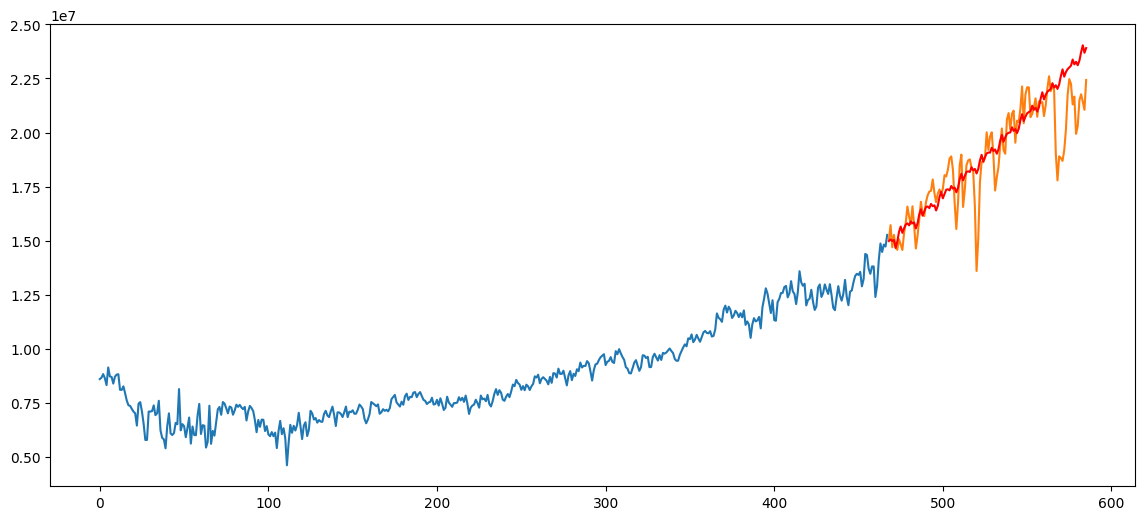

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train['Monthly oil production'])
plt.plot(test['Monthly oil production'])
plt.plot(predictions, color='red')
plt.show()

mape_ar: 0.18253856401943166
mape_ma: 0.1870842366847833
mape_arima: 0.2041843707405619
mape_sarima: 0.05029608850904263


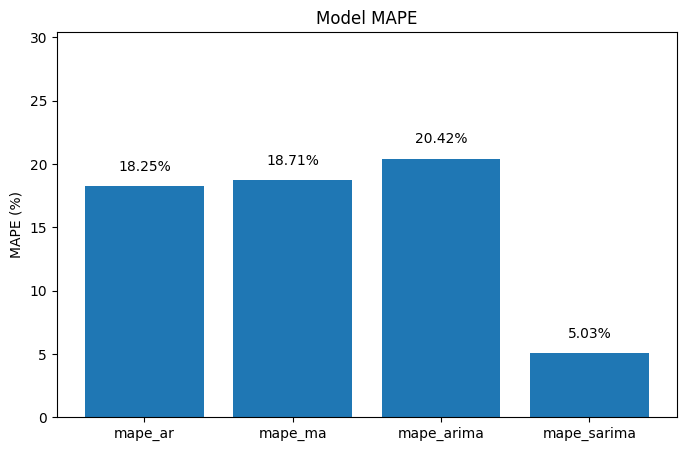

In [ ]:

print('mape_ar:', mape_ar)
print('mape_ma:', mape_ma)
print('mape_arima:', mape_arima)
print('mape_sarima:', mape_sarima)

methods = ['mape_ar', 'mape_ma', 'mape_arima', 'mape_sarima']
mape_values = [mape_ar, mape_ma, mape_arima, mape_sarima]

plt.figure(figsize=(8,5))
bars = plt.bar(methods, [m * 100 for m in mape_values], )

# Add percentage labels on top of bars
for bar, value in zip(bars, mape_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f'{value * 100:.2f}%', ha='center', va='bottom', fontsize=10)

plt.ylabel('MAPE (%)')
plt.title('Model MAPE')
plt.ylim(0, max(mape_values)*100 + 10)
plt.show()

In [5]:
ds= np.array(df['Monthly oil production'])
ds=ds.reshape(-1,1)
train_split = ds[:int(0.8*(len(ds)))]
test_split = ds[int(0.8*(len(ds))):]

In [6]:
def create_batchwise_data(data,time_steps):
  train_ds=[]
  test_ds=[]
  for i in range(len(data)-time_steps):
    train_ds.append(data[i:i+time_steps])
    test_ds.append(data[i+time_steps])
  return (np.array(train_ds),np.array(test_ds))

In [7]:
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,SimpleRNN,GRU,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error

#### HYPER TUNING - RNN


In [ ]:
best_RNN_model=[]
for input_shape_0 in range(10,21):

  x_train,y_train=create_batchwise_data(train_split,input_shape_0)
  x_test,y_test=create_batchwise_data(test_split,input_shape_0)

  def tuner_node_SimpleRNN(hp):
    model=Sequential()
    units = hp.Int('units',min_value=8,max_value=128,step=8)
    optimizer = hp.Choice('optimizer',values=['adam','rmsprop','sgd','adadelta'])
    model.add(SimpleRNN(units=units,activation='relu',input_shape=(input_shape_0,1)))

    model.add(Dense(1))
    model.compile(optimizer=optimizer,loss='mse',metrics=['mse','mape'])
    return model

  tuner_RNN = kt.RandomSearch(
    tuner_node_SimpleRNN,
    objective="val_mape",
    max_trials=5,
    directory="RNN",
    project_name=f"RNN_shape_{input_shape_0}"
  )

  tuner_RNN.search(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
  model = tuner_RNN.get_best_models()[0]
  hyperparameter = tuner_RNN.get_best_hyperparameters(1)[0].values
  best_RNN_model.append((hyperparameter,input_shape_0,model))


Trial 5 Complete [00h 00m 05s]
val_mape: 20.33767318725586

Best val_mape So Far: 0.23684902489185333
Total elapsed time: 00h 00m 30s


In [ ]:
min_error=1e9
hyperparameter=None
best_model=None
input_shape =None
history=None
counter=1
for i in best_RNN_model:
  input_shape = i[1]
  model = i[2]
  x_train,y_train=create_batchwise_data(train_split,input_shape)
  x_test,y_test=create_batchwise_data(test_split,input_shape)
  print("*"*50,counter,"*"*50)
  counter+=1

  early_stop=EarlyStopping(monitor = 'val_loss',patience = 15,verbose =False,restore_best_weights=True)
  history_dup=model.fit(x_train,y_train,epochs=1000,initial_epoch=11,validation_data=(x_test,y_test),callbacks=[early_stop])




************************************************** 1 **************************************************
Epoch 12/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.4001 - mape: 3.1159 - mse: 0.4001 - val_loss: 0.2102 - val_mape: 2.7124 - val_mse: 0.2102
Epoch 13/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0913 - mape: 1.6688 - mse: 0.0913 - val_loss: 0.0037 - val_mape: 0.2611 - val_mse: 0.0037
Epoch 14/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133 - mape: 0.5931 - mse: 0.0133 - val_loss: 0.0098 - val_mape: 0.5310 - val_mse: 0.0098
Epoch 15/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - mape: 0.3820 - mse: 0.0057 - val_loss: 0.0043 - val_mape: 0.2767 - val_mse: 0.0043
Epoch 16/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mape: 0.3451 - mse: 0.0054 - val_loss: 0.0037 - val_mape: 0.2552 - val_mse: 0.0037
Epoch 17/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mape: 0.2522 - mse: 0.0035 - val_loss: 0.0041 - val_mape

In [ ]:
min_mape_rnn =1e9
rnn_model=None
timesteps = None
hyperparameter=None
for i in best_RNN_model:
    input_shape = i[1]
    x_test,y_test = create_batchwise_data(test_split,input_shape)
    mape=mean_absolute_percentage_error(np.exp(y_test),np.exp(i[2].predict(x_test)))
    print("*"*100)
    print("MAPE : ",mape)
    if mape<min_mape_rnn:
        min_mape_rnn=mape
        rnn_model=i[2]
        hyperparameter=i[0]
        timesteps=i[1]



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
****************************************************************************************************
MAPE :  0.04341006869765908
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
****************************************************************************************************
MAPE :  0.13468419302884377


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
****************************************************************************************************
MAPE :  0.04616517408115234
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
****************************************************************************************************
MAPE :  0.23556168036517633
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
****************************************************************************************************
MAPE :  0.045484888253162215
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
****************************************************************************************************
MAPE :  0.04664276626802505
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
****************************************************************************************************
MAPE :  0.04377645098148046
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
****************************************************************************************************
MAPE :  0.043239161727540

************************************************** RNN **************************************************
Hyperparameter :  {'units': 96, 'optimizer': 'adam'}
input_shape=(20,1)
**************************************************


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 96)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

Best Model: None
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
MAPE :  0.04388062076801769
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


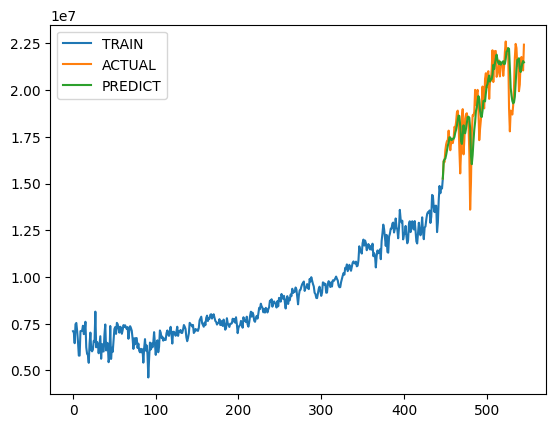

In [23]:
x_train,y_train = create_batchwise_data(train_split,timesteps)
x_test,y_test = create_batchwise_data(test_split,timesteps)
print("*"*50,"RNN","*"*50)
print("Hyperparameter : ",hyperparameter)
print(f"input_shape=({timesteps},1)")
print("*"*50)
print("Best Model:",rnn_model.summary())
print("MAPE : ", mean_absolute_percentage_error(np.exp(y_test),np.exp(rnn_model.predict(x_test))))
plt.plot(range(len(y_train)), np.exp(y_train), label='TRAIN')
plt.plot(range(len(y_train)-1, len(y_train)+len(y_test)),np.concatenate([[np.exp(y_train[-1])], np.exp(y_test)]), label='ACTUAL')
plt.plot(range(len(y_train)-1, len(y_train)+len(y_test)), np.concatenate([[np.exp(y_train[-1])], np.exp(rnn_model.predict(x_test))]), label='PREDICT')
plt.legend()
plt.show()

### HYPER TUNIG - LSTM

In [ ]:
best_LSTM_model=[]
for input_shape_0 in range(10,21):

  x_train,y_train=create_batchwise_data(train_split,input_shape_0)
  x_test,y_test=create_batchwise_data(test_split,input_shape_0)

  def tuner_node_LSTM(hp):
    model=Sequential()
    units = hp.Int('units',min_value=8,max_value=128,step=8)
    optimizer = hp.Choice('optimizer',values=['adam','rmsprop','sgd','adadelta'])
    model.add(LSTM(units=units,activation='tanh',input_shape=(input_shape_0,1)))

    model.add(Dense(1))
    model.compile(optimizer=optimizer,loss='mse',metrics=['mse','mape'])
    return model

  tuner_LSTM = kt.RandomSearch(
    tuner_node_LSTM,
    objective="val_mape",
    max_trials=5,
    directory="LSTM",
    project_name=f"LSTM_shape_{input_shape_0}"
  )

  tuner_LSTM.search(x_train,y_train,epochs=20,validation_data=(x_test,y_test))
  model = tuner_LSTM.get_best_models()[0]
  hyperparameter = tuner_LSTM.get_best_hyperparameters(1)[0].values
  best_LSTM_model.append((hyperparameter,input_shape_0,model))


Trial 5 Complete [00h 00m 11s]
val_mape: 0.99368816614151

Best val_mape So Far: 0.99368816614151
Total elapsed time: 00h 00m 57s


In [ ]:
min_error=1e9
hyperparameter=None
best_model=None
input_shape =None
history=None
for i in best_LSTM_model:
  input_shape = i[1]
  model = i[2]
  x_train,y_train=create_batchwise_data(train_split,input_shape)
  x_test,y_test=create_batchwise_data(test_split,input_shape)

  early_stop=EarlyStopping(monitor='val_mape',patience=15,restore_best_weights=True)
  history_dup=model.fit(x_train,y_train,epochs=1000,initial_epoch=21,validation_data=(x_test,y_test),verbose=False,callbacks=[early_stop])






In [ ]:
min_mape_lstm =1e9
lstm_model=None
timesteps = None
hyperparameter=None
for i in best_LSTM_model:
    input_shape = i[1]
    x_test,y_test = create_batchwise_data(test_split,input_shape)
    mape=mean_absolute_percentage_error(np.exp(y_test),np.exp(i[2].predict(x_test)))
    print("MAPE : ",mape)
    if mape<min_mape_lstm:
        min_mape_lstm=mape
        lstm_model=i[2]
        hyperparameter=i[0]
        timesteps=i[1]



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
MAPE :  0.04624348555578686
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
MAPE :  0.07059825778651803
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
MAPE :  0.039757304873779944
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
MAPE :  0.04369642091323012
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
MAPE :  0.04714411029313763
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
MAPE :  0.05659662653387032
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
MAPE :  0.06794156060775493
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
MAPE :  0.043322396969561715
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
MAPE :  0.04872354419403714
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
MAPE :  0.04654803104531423
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
MAPE :  0.09402874687972095


************************************************** LSTM **************************************************
Hyperparameter :  {'units': 32, 'optimizer': 'adam'}
input_shape=(18,1)
**************************************************


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Best Model: None
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
MAPE :  0.03575319292952758
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


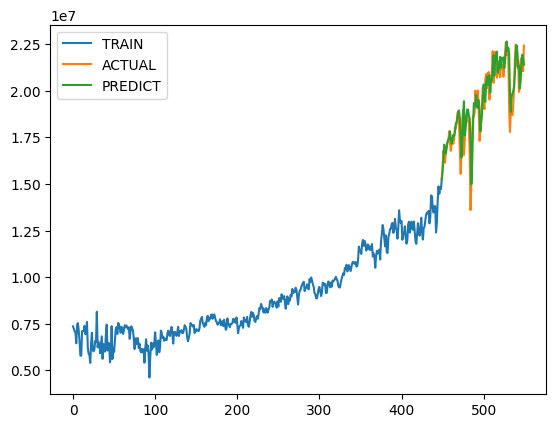

In [20]:
x_train,y_train = create_batchwise_data(train_split,timesteps)
x_test,y_test = create_batchwise_data(test_split,timesteps)
print("*"*50,"LSTM","*"*50)
print("Hyperparameter : ",hyperparameter)
print(f"input_shape=({timesteps},1)")
print("*"*50)
print("Best Model:",lstm_model.summary())
print("MAPE : ", mean_absolute_percentage_error(np.exp(y_test),np.exp(lstm_model.predict(x_test))))
plt.plot(range(len(y_train)), np.exp(y_train), label='TRAIN')
plt.plot(range(len(y_train)-1, len(y_train)+len(y_test)),np.concatenate([[np.exp(y_train[-1])], np.exp(y_test)]), label='ACTUAL')
plt.plot(range(len(y_train)-1, len(y_train)+len(y_test)), np.concatenate([[np.exp(y_train[-1])], np.exp(lstm_model.predict(x_test))]), label='PREDICT')
plt.legend()
plt.show()

#### HYPER TUNING - GRU

In [ ]:
best_GRU_model=[]
for input_shape_0 in range(10,21):

  x_train,y_train=create_batchwise_data(train_split,input_shape_0)
  x_test,y_test=create_batchwise_data(test_split,input_shape_0)

  def tuner_node_GRU(hp):
    model=Sequential()
    units = hp.Int('units',min_value=8,max_value=128,step=8)
    optimizer = hp.Choice('optimizer',values=['adam','rmsprop','sgd','adadelta'])
    model.add(GRU(units=units,activation='tanh',input_shape=(input_shape_0,1)))

    model.add(Dense(1))
    model.compile(optimizer=optimizer,loss='mse',metrics=['mse','mape'])
    return model

  tuner_GRU = kt.RandomSearch(
    tuner_node_GRU,
    objective="val_mape",
    max_trials=5,
    directory="GRU",
    project_name=f"GRU_shape_{input_shape_0}"
  )

  tuner_GRU.search(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
  model = tuner_GRU.get_best_models()[0]
  hyperparameter = tuner_GRU.get_best_hyperparameters(1)[0].values
  best_GRU_model.append((hyperparameter,input_shape_0,model))


Trial 5 Complete [00h 00m 10s]
val_mape: 98.4434814453125

Best val_mape So Far: 0.2780180275440216
Total elapsed time: 00h 00m 54s


In [ ]:
min_error=1e9
hyperparameter=None
best_model=None
input_shape =None
history=None
for i in best_GRU_model:
  input_shape = i[1]
  model = i[2]
  x_train,y_train=create_batchwise_data(train_split,input_shape)
  x_test,y_test=create_batchwise_data(test_split,input_shape)

  early_stop=EarlyStopping(monitor='val_mape',patience=15,restore_best_weights=True)
  history_dup=model.fit(x_train,y_train,epochs=1000,initial_epoch=11,validation_data=(x_test,y_test),verbose=False,callbacks=[early_stop])
  min_index = np.argmin(history_dup.history['val_mape'])
  mape=history_dup.history['val_mape'][min_index]
  if mape < min_error:
    min_error=mape
    hyperparameter=i[0]
    best_model=model
    input_shape=i[1]
    history=history_dup



In [ ]:
min_mape_gru =1e9
gru_model=None
timesteps = None
hyperparameter=None
for i in best_GRU_model:
    print(i[0],i[1])
    mape=mean_absolute_percentage_error(np.exp(y_test),np.exp(i[2].predict(x_test)))
    print(mape)
    if mape<min_mape_gru:
        min_mape_gru=mape
        gru_model=i[2]
        hyperparameter=i[0]
        timesteps=i[1]




{'units': 88, 'optimizer': 'adam'} 10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1.552670143596305
{'units': 72, 'optimizer': 'adam'} 11
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
0.6173102981601364
{'units': 96, 'optimizer': 'adam'} 12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
0.19440110414845388
{'units': 128, 'optimizer': 'adam'} 13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
0.09127062368283692
{'units': 88, 'optimizer': 'adam'} 14
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
0.312659206148567
{'units': 40, 'optimizer': 'rmsprop'} 15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
0.382385272023132
{'units': 72, 'optimizer': 'rmsprop'} 16
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
0.12009228594108419
{'units': 80, 'optimizer': 'adam'} 17
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
0.11246978966697439
{'units': 24, 'optimizer': 'rmsprop'} 18
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
0.04811175804190166
{'units': 120, 'optimizer': 'adam'} 19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
0.04809626661223049
{'units': 80, 'optimizer': 'adam'} 

************************************************** GRU **************************************************
Hyperparameter :  {'units': 32, 'optimizer': 'adam'}
input_shape=(20,1)
**************************************************


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Best Model: None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAPE :  0.043051519034669576
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


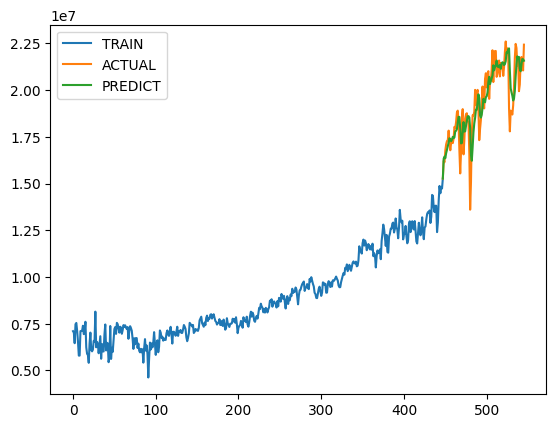

In [26]:
x_train,y_train = create_batchwise_data(train_split,timesteps)
x_test,y_test = create_batchwise_data(test_split,timesteps)
print("*"*50,"GRU","*"*50)
print("Hyperparameter : ",hyperparameter)
print(f"input_shape=({timesteps},1)")
print("*"*50)
print("Best Model:",gru_model.summary())
print("MAPE : ", mean_absolute_percentage_error(np.exp(y_test),np.exp(gru_model.predict(x_test))))
plt.plot(range(len(y_train)), np.exp(y_train), label='TRAIN')
plt.plot(range(len(y_train)-1, len(y_train)+len(y_test)),np.concatenate([[np.exp(y_train[-1])], np.exp(y_test)]), label='ACTUAL')
plt.plot(range(len(y_train)-1, len(y_train)+len(y_test)), np.concatenate([[np.exp(y_train[-1])], np.exp(gru_model.predict(x_test))]), label='PREDICT')
plt.legend()
plt.show()

mape_lstm: 0.03575319292952758
mape_gru: 0.043051519034669576
mape_rnn: 0.04388062076801769


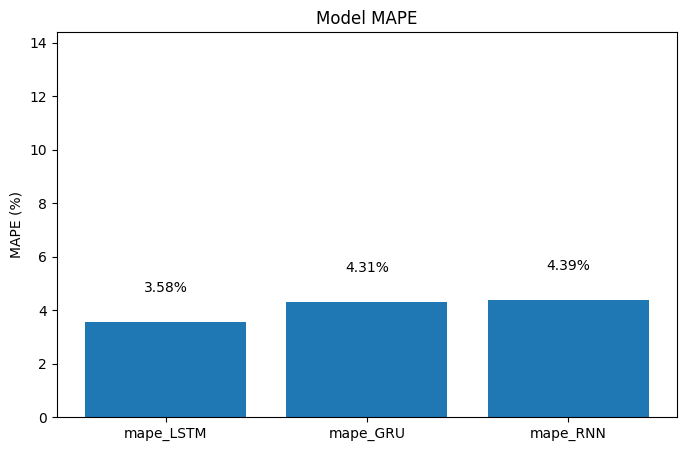

In [32]:

print('mape_lstm:', min_mape_lstm)
print('mape_gru:', min_mape_gru)
print('mape_rnn:', min_mape_rnn)


methods = ['mape_LSTM', 'mape_GRU', 'mape_RNN']
mape_values = [min_mape_lstm, min_mape_gru, min_mape_rnn]

plt.figure(figsize=(8,5))
bars = plt.bar(methods, [m * 100 for m in mape_values], )

# Add percentage labels on top of bars
for bar, value in zip(bars, mape_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f'{value * 100:.2f}%', ha='center', va='bottom', fontsize=10)

plt.ylabel('MAPE (%)')
plt.title('Model MAPE')
plt.ylim(0, max(mape_values)*100 + 10)
plt.show()